# Load torch device

In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW

# --- this part is required for mac --- #
import sys, os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# comment out if youre on windows and remove 'src.' prefixes from imports #

from src.Datasets.batching import BatchManager

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Choose NCars or NCaltech-101 Dataset

In [2]:
from src.Datasets.ncaltech101 import NCaltech
from src.Datasets.ncars import NCars

# options: 'ncars' or 'ncaltech'
dataset = 'ncars'
#dataset = 'ncaltech'

if dataset == 'ncars':
    num_classes = len(NCars.get_info().classes)
    image_size: tuple[int, int] = NCars.get_info().image_size  # (height=240, width=180)
if dataset == 'ncaltech':
    num_classes = len(NCaltech.get_info().classes)
    image_size: tuple[int, int] = NCaltech.get_info().image_size  # (height=240, width=180)

# Model Initialization

In [3]:
from src.Models.CleanEvGNN.recognition import RecognitionModel as EvGNN
from torch_geometric.data import Data as PyGData
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape: tuple[int, int, int] = (*image_size, 3)

# Vertausche Dimensionen: pos ist [x, y] = [width, height], also übergeben wir (width, height)
img_shape_for_model = (image_size[1], image_size[0])  # (180, 240) statt (240, 180)

evgnn = EvGNN(
    network="graph_res",
    dataset=dataset,
    num_classes = num_classes,
    img_shape=img_shape_for_model,  # (width=180, height=240)
    dim=3,
    conv_type="fuse",
    distill=False,        # <– no KD, just normal training
).to(device)


def transform_graph(graph: PyGData) -> PyGData:
    return evgnn.data_transform(
        graph, n_samples=10000, sampling=True,
        beta=0.5e-5, radius=3.0,
        max_neighbors=16
    ).to(device)

/opt/anaconda3/envs/GNNBenchmark/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


# Dataset Initialization and processing (from the parsed dataset from the aegnn issues thread)

In [4]:
#Instantiating the ncaltech dataset
if dataset == 'ncaltech':
    dataset_obj = NCaltech(
        root=r'/Users/hannes/Documents/University/Datasets/raw_ncaltec',
        #root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/N-Caltech101',
        transform=transform_graph
    )
if dataset == 'ncars':
    dataset_obj = NCars(
        root=r'/Users/hannes/Documents/University/Datasets/raw_ncars/Prophesee_Dataset_n_cars',
        #root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/Prophesee_Dataset_n_cars',
        transform=transform_graph
)

# Processing the training part of the dataset
dataset_obj.process(modes = ["training"])

#Check how many samples are available
num_training_samples = dataset_obj.get_mode_length("training")
print(f"Number of training samples: {num_training_samples}")


Number of training samples: 13879


Display example events data point

In [5]:

training_set = BatchManager(
    dataset=dataset_obj,
    batch_size=32,
    mode="training"
)

In [6]:
# Optimizer and scheduler configuration
optimizer = Adam(evgnn.parameters(), lr=5e-4, weight_decay=6e-7)

# Original scheduler (currently active)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, cooldown=10)

# Paper's hyperparameters and schedule (commented out - uncomment to match paper exactly)
# optimizer = Adam(evgnn.parameters(), lr=1e-3, weight_decay=5e-3)
# class LRPolicy(object):
#     def __call__(self, iteration: int):
#         # Convert iterations to approximate epochs (assuming ~230 iterations per epoch with batch=32)
#         epoch = iteration // 230
#         if epoch < 20:
#             return 1.0
#         elif epoch >= 20 and epoch < 50:
#             return 0.5
#         else:
#             return 0.1
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=LRPolicy())

loss_fn = CrossEntropyLoss()

classes = dataset_obj.get_info().classes

cls_to_idx = dict(zip(classes, range(len(classes))))

In [7]:
def label_to_index(lbl):
    if isinstance(lbl,str): # for n-caltech labels (strings)
        return cls_to_idx[lbl]
    if isinstance(lbl, torch.Tensor): # for ncars labels (tensors)
        return int(lbl.item())  

In [ ]:
evgnn.train()
losses = []

# Add diagnostics for first batch
first_batch = True

# EMA for smoother loss display
ema_loss = None
ema_alpha = 0.9

print(f"Training fuse architecture for {10000} iterations to match paper performance...")
print(f"Expected result: 89-91% accuracy on NCars\n")

for i in range(10000):  # Paper trains for many more iterations (~50 epochs)
    optimizer.zero_grad()

    examples = next(training_set)
    # Use .y directly - this is how PyG batches labels
    reference = examples.y.to(device)

    # Diagnostic output for first batch
    if first_batch:
        print(f"\n=== First Batch Diagnostics ===")
        print(f"Batch size: {examples.batch.max().item() + 1}")
        print(f"Num nodes: {examples.x.shape[0]}")
        print(f"Num edges: {examples.edge_index.shape[1]}")
        print(f"Feature shape: {examples.x.shape}")
        print(f"Position range: x=[{examples.pos[:,0].min():.2f}, {examples.pos[:,0].max():.2f}], y=[{examples.pos[:,1].min():.2f}, {examples.pos[:,1].max():.2f}], t=[{examples.pos[:,2].min():.6f}, {examples.pos[:,2].max():.6f}]")
        print(f"Labels (y): {reference}")
        print(f"Label distribution: {torch.bincount(reference)}")
        if hasattr(examples, 'edge_attr') and examples.edge_attr is not None:
            print(f"Edge attr shape: {examples.edge_attr.shape}")
            print(f"Edge attr sample: {examples.edge_attr[:5]}")
        first_batch = False

    out = evgnn(examples)
    loss = loss_fn(out, reference)

    # Check for NaN/Inf
    if torch.isnan(loss) or torch.isinf(loss):
        print(f"\n!!! Loss is NaN/Inf at iteration {i} !!!")
        break

    loss.backward()

    # Gradient Clipping für Stabilität
    torch.nn.utils.clip_grad_norm_(evgnn.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step(loss.item())  # ReduceLROnPlateau needs loss value
    # Note: If using LambdaLR (paper's schedule), change to: scheduler.step()

    # Update EMA loss for smoother display
    if ema_loss is None:
        ema_loss = loss.item()
    else:
        ema_loss = ema_alpha * ema_loss + (1 - ema_alpha) * loss.item()

    # Show predictions for first few iterations
    if i < 5 or i % 100 == 0:  # Changed to every 100 iterations
        with torch.no_grad():
            predictions = out.argmax(dim=-1)
            accuracy = (predictions == reference).float().mean().item()
            # current_lr = scheduler.get_last_lr()[0]  # Only works with LambdaLR
            print(f"Iteration {i:4d} | Loss: {loss.item():.4f} (EMA: {ema_loss:.4f}) | Acc: {accuracy:.3f}")
    elif i % 50 == 0:
        print(f"Iteration {i:4d} | Loss: {loss.item():.4f} (EMA: {ema_loss:.4f})")

    losses.append(loss.item())

print(f"\n✅ Training complete! Final EMA loss: {ema_loss:.4f}")
torch.save(evgnn.state_dict(), f"evgnn_{dataset}_fuse_test.pth")
# i removed the time window in the data_transform function to make it work with ncaltech, maybe that could be a problem


=== First Batch Diagnostics ===
Batch size: 32
Num nodes: 170594
Num edges: 2645945
Feature shape: torch.Size([170594, 1])
Position range: x=[0.00, 110.00], y=[0.00, 99.00], t=[0.000000, 0.000000]
Labels (y): tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1])
Label distribution: tensor([14, 18])
Edge attr shape: torch.Size([2645945, 3])
Edge attr sample: tensor([[0.5000, 0.5500, 0.5000],
        [0.5000, 0.5500, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5500, 0.5000],
        [0.5000, 0.5000, 0.5000]])
Iteration   0 | Loss: 0.9071 | Acc: 0.312 | Pred: [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0] | True: [0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1]
Iteration   1 | Loss: 0.7221 | Acc: 0.438 | Pred: [1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1] | True: [1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1]
Iteration   2 | Loss: 0.7775 

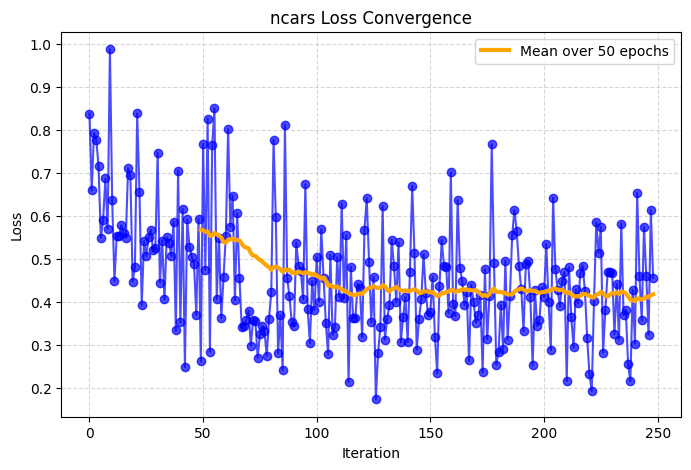

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_convergence(loss_list, window=50, title=None, xlabel="Iteration", ylabel="Loss"):
    """
    Plots the loss over iterations to visualize convergence.

    Parameters:
    - loss_list: List or array of loss values over iterations
    - title: Plot title
    - xlabel: X-axis label
    - ylabel: Y-axis label
    """
    if title is None:
        title = f"{dataset} Loss Convergence"

    plt.figure(figsize=(12,5))

    # Plot raw loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, alpha=0.3, color='blue', label='Raw loss')
    moving_mean = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_mean, color='orange', linewidth=2, label=f'Moving avg (window={window})')
    plt.title(f"{title} - With Smoothing")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Plot smoothed loss only
    plt.subplot(1, 2, 2)
    plt.plot(range(window-1, len(loss_list)), moving_mean, color='orange', linewidth=2)
    plt.title(f"{title} - Smoothed Only")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nLoss Statistics:")
    print(f"  Initial loss: {loss_list[0]:.4f}")
    print(f"  Final loss: {loss_list[-1]:.4f}")
    print(f"  Final smoothed loss: {moving_mean[-1]:.4f}")
    print(f"  Reduction: {(loss_list[0] - moving_mean[-1]) / loss_list[0] * 100:.1f}%")

plot_loss_convergence(losses)

In [33]:
evgnn.eval()
predictions_made = 0
correct = 0
with torch.no_grad():
    for i in range(50):
        examples = next(training_set)
        reference = examples.y.to(device)
        out = evgnn(examples)
        prediction = out.argmax(dim = -1)
        is_correct = prediction - reference
        is_correct = is_correct[is_correct == 0]
        correct += is_correct.shape[0]
        predictions_made += prediction.shape[0]

        print(f"Accuracy: {correct / predictions_made}")

print(f"Accuracy: {correct / predictions_made}")

Accuracy: 0.75
Accuracy: 0.8125
Accuracy: 0.875
Accuracy: 0.875
Accuracy: 0.8625
Accuracy: 0.8541666666666666
Accuracy: 0.8660714285714286
Accuracy: 0.875
Accuracy: 0.875
Accuracy: 0.8625
Accuracy: 0.8522727272727273
Accuracy: 0.84375
Accuracy: 0.8365384615384616
Accuracy: 0.84375
Accuracy: 0.8416666666666667
Accuracy: 0.83984375
Accuracy: 0.8345588235294118
Accuracy: 0.8333333333333334
Accuracy: 0.8355263157894737
Accuracy: 0.834375
Accuracy: 0.8392857142857143
Accuracy: 0.8380681818181818
Accuracy: 0.842391304347826
Accuracy: 0.8463541666666666
Accuracy: 0.85
Accuracy: 0.8509615384615384
Accuracy: 0.8541666666666666
Accuracy: 0.8526785714285714
Accuracy: 0.8512931034482759
Accuracy: 0.8541666666666666
Accuracy: 0.8548387096774194
Accuracy: 0.85546875
Accuracy: 0.8522727272727273
Accuracy: 0.8529411764705882
Accuracy: 0.8482142857142857
Accuracy: 0.84375
Accuracy: 0.8462837837837838
Accuracy: 0.8421052631578947
Accuracy: 0.842948717948718
Accuracy: 0.8453125
Accuracy: 0.84298780487804